## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [0]:
%sh 
pip install nltk
python -m nltk.downloader all

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

from textblob import TextBlob

In [0]:
# File location and type
file_location = "/FileStore/tables/music.json"
file_type = "json"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
reviews = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(reviews)

asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
1384719342,"List(0, 0)",5.0,"Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,","02 28, 2014",A2IBPI20UZIR0U,"cassandra tu ""Yeah, well, that's just like, u...",good,1393545600
1384719342,"List(13, 14)",5.0,"The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]","03 16, 2013",A14VAT5EAX3D9S,Jake,Jake,1363392000
1384719342,"List(1, 1)",5.0,"The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it.","08 28, 2013",A195EZSQDW3E21,"Rick Bennette ""Rick Bennette""",It Does The Job Well,1377648000
1384719342,"List(0, 0)",5.0,Nice windscreen protects my MXL mic and prevents pops. Only thing is that the gooseneck is only marginally able to hold the screen in position and requires careful positioning of the clamp to avoid sagging.,"02 14, 2014",A2C00NNG1ZQQG2,"RustyBill ""Sunday Rocker""",GOOD WINDSCREEN FOR THE MONEY,1392336000
1384719342,"List(0, 0)",5.0,This pop filter is great. It looks and performs like a studio filter. If you're recording vocals this will eliminate the pops that gets recorded when you sing.,"02 21, 2014",A94QU4C90B1AX,SEAN MASLANKA,No more pops when I record my vocals.,1392940800
B00004Y2UT,"List(0, 0)",5.0,"So good that I bought another one. Love the heavy cord and gold connectors. Bass sounds great. I just learned last night how to coil them up. I guess I should read instructions more carefully. But no harm done, still works great!","12 21, 2012",A2A039TZMZHH9Y,"Bill Lewey ""blewey""",The Best Cable,1356048000
B00004Y2UT,"List(0, 0)",5.0,"I have used monster cables for years, and with good reason. The lifetime warranty is worth the price alone. Simple fact: cables break, but getting to replace them at no cost is where it's at.","01 19, 2014",A1UPZM995ZAH90,Brian,Monster Standard 100 - 21' Instrument Cable,1390089600
B00004Y2UT,"List(0, 0)",3.0,I now use this cable to run from the output of my pedal chain to the input of my Fender Amp. After I bought Monster Cable to hook up my pedal board I thought I would try another one and update my guitar. I had been using a high end Planet Waves cable that I bought in the 1980's... Once I found out the input jacks on the new Monster cable didn't fit into the Fender Strat jack I was a little disappointed... I didn't return it and as stated I use it for the output on the pedal board. Save your money... I went back to my Planet Waves Cable...I payed $30.00 back in the eighties for the Planet Waves which now comes in at around $50.00. What I'm getting at is you get what you pay for. I thought Waves was a lot of money back in the day...but I haven't bought a guitar cable since this one...20 plus years and still working...Planet Waves wins.,"11 16, 2012",AJNFQI3YR6XJ5,"Fender Guy ""Rick""",Didn't fit my 1996 Fender Strat...,1353024000
B00004Y2UT,"List(0, 0)",5.0,Perfect for my Epiphone Sheraton II. Monster cables are well c

In [0]:
# Create a view or table

temp_table_name = "reviews"

df.createOrReplaceTempView(temp_table_name)

In [0]:
%sql

/* Query the created temp table in a SQL cell */

select reviewText, overall from `reviews`

reviewText,overall
"Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,",5.0
"The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]",5.0
"The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it.",5.0
Nice windscreen protects my MXL mic and prevents pops. Only thing is that the gooseneck is only marginally able to hold the screen in position and requires careful positioning of the clamp to avoid sagging.,5.0
This pop filter is great. It looks and performs like a studio filter. If you're recording vocals this will eliminate the pops that gets recorded when you sing.,5.0
"So good that I bought another one. Love the heavy cord and gold connectors. Bass sounds great. I just learned last night how to coil them up. I guess I should read instructions more carefully. But no harm done, still works great!",5.0
"I have used monster cables for years, and with good reason. The lifetime warranty is worth the price alone. Simple fact: cables break, but getting to replace them at no cost is where it's at.",5.0
I now use this cable to run from the output of my pedal chain to the input of my Fender Amp. After I bought Monster Cable to hook up my pedal board I thought I would try another one and update my guitar. I had been using a high end Planet Waves cable that I bought in the 1980's... Once I found out the input jacks on the new Monster cable didn't fit into the Fender Strat jack I was a little disappointed... I didn't return it and as stated I use it for the output on the pedal board. Save your money... I went back to my Planet Waves Cable...I payed $30.00 back in the eighties for the Planet Waves which now comes in at around $50.00. What I'm getting at is you get what you pay for. I thought Waves was a lot of money back in the day...but I haven't bought a guitar cable since this one...20 plus years and still working...Planet Waves wins.,3.0
Perfect for my Epiphone Sheraton II. Monster cables are well constructed. I have several and never had any problems with any of them over the years. Got this one because I wanted the 90 degree plug.,5.0
Monster makes the best cables and a lifetime warranty doesnt hurt either. This isnt their top of the line series but it works great with my bass guitar rig and has for some time. You cant go wrong with Monster Cables.,5.0


In [0]:
# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.

permanent_table_name = "music_json"

df.write.format("parquet").saveAsTable(permanent_table_name)

In [0]:
reviews.printSchema()

root
-- asin: string (nullable = true)
-- helpful: array (nullable = true)
 |-- element: long (containsNull = true)
-- overall: double (nullable = true)
-- reviewText: string (nullable = true)
-- reviewTime: string (nullable = true)
-- reviewerID: string (nullable = true)
-- reviewerName: string (nullable = true)
-- summary: string (nullable = true)
-- unixReviewTime: long (nullable = true)

Filter out null reviews

In [0]:
reviews = reviews.filter(reviews.reviewText.isNotNull())

reviews.createOrReplaceTempView('reviews'): Creates a new temporary view using a SparkDataFrame in the Spark Session. If a temporary view with the same name already exists, replaces it.

In [0]:
reviews.createOrReplaceTempView('reviews')

In [0]:
spark.sql('SELECT COUNT(*) FROM reviews').toPandas()

,count(1)
0,10261


In [0]:
spark.sql('SELECT * FROM reviews LIMIT 2').toPandas()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1384719342,"[0, 0]",5.0,"Not much to write about here, but it does exac...","02 28, 2014",A2IBPI20UZIR0U,"cassandra tu ""Yeah, well, that's just like, u...",good,1393545600
1,1384719342,"[13, 14]",5.0,The product does exactly as it should and is q...,"03 16, 2013",A14VAT5EAX3D9S,Jake,Jake,1363392000


See who has posted the most reviews

In [0]:
query = '''
SELECT reviewerName, reviewerID, COUNT(*) as num_reviews
FROM reviews
GROUP BY reviewerID, reviewerName
ORDER BY num_reviews DESC
'''
spark.sql(query).show(truncate=50)

+-------------------------------+--------------+-----------+
 reviewerName| reviewerID|num_reviews|
+-------------------------------+--------------+-----------+
 StormJH1| ADH0O8UVJOT10| 42|
 David G|A1L7M2JXN4EZCR| 38|
 David W "Dave"|A15TYOEWBQYF0X| 38|
 Charlo|A2EZWZ8MBEDOLN| 36|
 Mike Tarrani "Jazz Drummer"|A2NYK9KWFMJV4Y| 34|
guitfiddleblue "guitfiddleblue"|A1SD1C8XK3Z3V1| 32|
 Captn' Bob|A1MVH1WLYDHZ49| 32|
 MetalFan|A1GMWTGXW682GB| 29|
 Dako "Dako"|A34O0KQV4QXWNQ| 28|
 David Burch|A1LQC225SE8UNI| 27|
 aceofbase| AJK15Q9JOEHRH| 25|
 AF "Whigs"|A22Z554ZQ8NFPC| 25|
 grandpa "Randy"|A1DVUFG2QSJ6IK| 24|
 G. Thomas "Tom"|A3M1PLEYNDEYO8| 24|
 R. W. Milyard "GearJunky"| AKYDGCKCY7H9F| 23|
 StudioDude| A2F92AOWTIUIB| 23|
 Michael Livote "dragon2knight"| A781ITP3HE2N5| 22|
 Samuel Chell| A6FIAB28IS79| 21|
 bayou bob|A26SN2CVQM4FKM| 21|
 Tachyon|A3ITN3125FJETP| 21|
+-------------------------------+--------------+-----------+
only showing top 20 rows

In [0]:
%python
df2 = df.drop('asin','helpful','reviewTime','reviewerID','reviewerName','summary','unixReviewTime')
display(df2)

overall,reviewText
5.0,"Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,"
5.0,"The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]"
5.0,"The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it."
5.0,Nice windscreen protects my MXL mic and prevents pops. Only thing is that the gooseneck is only marginally able to hold the screen in position and requires careful positioning of the clamp to avoid sagging.
5.0,This pop filter is great. It looks and performs like a studio filter. If you're recording vocals this will eliminate the pops that gets recorded when you sing.
5.0,"So good that I bought another one. Love the heavy cord and gold connectors. Bass sounds great. I just learned last night how to coil them up. I guess I should read instructions more carefully. But no harm done, still works great!"
5.0,"I have used monster cables for years, and with good reason. The lifetime warranty is worth the price alone. Simple fact: cables break, but getting to replace them at no cost is where it's at."
3.0,I now use this cable to run from the output of my pedal chain to the input of my Fender Amp. After I bought Monster Cable to hook up my pedal board I thought I would try another one and update my guitar. I had been using a high end Planet Waves cable that I bought in the 1980's... Once I found out the input jacks on the new Monster cable didn't fit into the Fender Strat jack I was a little disappointed... I didn't return it and as stated I use it for the output on the pedal board. Save your money... I went back to my Planet Waves Cable...I payed $30.00 back in the eighties for the Planet Waves which now comes in at around $50.00. What I'm getting at is you get what you pay for. I thought Waves was a lot of money back in the day...but I haven't bought a guitar cable since this one...20 plus years and still working...Planet Waves wins.
5.0,Perfect for my Epiphone Sheraton II. Monster cables are well constructed. I have several and never had any problems with any of them over the years. Got this one because I wanted the 90 degree plug.
5.0,Monster makes the best cables and a lifetime warranty doesnt hurt either. This isnt their top of the line series but it works great with my bass guitar rig and has for some time. You cant go wrong with Monster Cables.


Number of reviews over time

Obviously as Amazon became more popular, the number of reviews grew

In [0]:
spark.sql('SELECT MIN(YEAR(FROM_UNIXTIME(unixReviewTime))) AS min_year FROM reviews').toPandas()

,min_year
0,2004


In [0]:
spark.sql('SELECT MAX(YEAR(FROM_UNIXTIME(unixReviewTime))) AS max_year FROM reviews').toPandas()

,max_year
0,2014


In [0]:
query = '''
SELECT COUNT(*) as num_reviews_per_year, YEAR(FROM_UNIXTIME(unixReviewTime)) AS year 
FROM reviews 
GROUP BY year 
ORDER BY year DESC
'''

spark.sql(query).toPandas()

,num_reviews_per_year,year
0,2679,2014
1,4055,2013
2,1936,2012
3,1007,2011
4,350,2010
5,128,2009
6,63,2008
7,22,2007
8,10,2006
9,4,2005


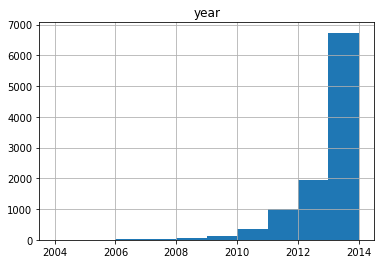

In [0]:
spark.sql('SELECT YEAR(FROM_UNIXTIME(unixReviewTime)) AS year FROM reviews').toPandas().hist();

It seems most reviews are actually 5 stars!

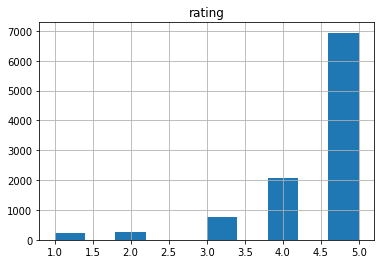

In [0]:
spark.sql('SELECT overall AS rating FROM reviews').toPandas().hist();

### Show products with the most reviews

TODO: Need to pull out all products that appear in the reviews from product metadata

In [0]:
query = '''
SELECT asin, COUNT(*) as num_reviews
FROM reviews
GROUP BY asin
ORDER BY num_reviews DESC
'''
spark.sql(query).show(truncate=50)

+----------+-----------+
 asin|num_reviews|
+----------+-----------+
B003VWJ2K8| 163|
B0002E1G5C| 143|
B0002F7K7Y| 116|
B003VWKPHC| 114|
B0002H0A3S| 93|
B0002CZVXM| 74|
B0006NDF8A| 71|
B0009G1E0K| 69|
B0002E2KPC| 68|
B0002GLDQM| 67|
B004XNK7AI| 65|
B005FKF1PY| 63|
B00646MZHK| 62|
B0002GMGYA| 58|
B001PGXHX0| 58|
B000978D58| 57|
B0018TIADQ| 57|
B0002D0CEO| 55|
B001PGXKC8| 55|
B000068NW5| 52|
+----------+-----------+
only showing top 20 rows

## Bag of Words
- I will use NLTK's list of stopwords to conduct stopword removal, and visualise results in wordclouds

In [0]:
sw = stopwords.words("english")
def remove_stopwords(x):    
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
        else:
            pass
    return string

# UDF = user defined function
nosw = udf(remove_stopwords)
# Register UDF with Spark
spark.udf.register("nosw", nosw)
# Creates a new column in reviews which contains the review with no stop words
reviews = reviews.withColumn('text_nosw', nosw('reviewText'))

In [0]:
reviews.select('text_nosw').toPandas()

,text_nosw
0,"much write here, exactly supposed to. filters ..."
1,product exactly quite affordable.I realized do...
2,primary job device block breath would otherwis...
3,Nice windscreen protects MXL mic prevents pops...
4,pop filter great. looks performs like studio f...
...,...
10256,"Great, expected. Thank all."
10257,"I've thinking trying Nanoweb strings while, bi..."
10258,tried coated strings past ( including Elixirs)...
10259,"Well, MADE Elixir DEVELOPED Taylor Guitars ......"


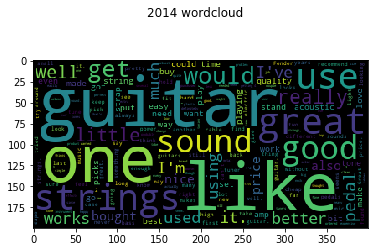

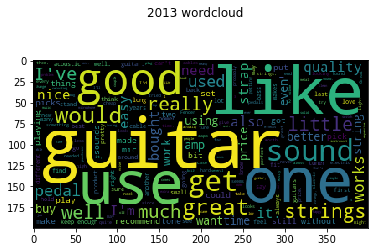

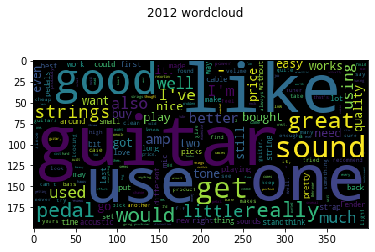

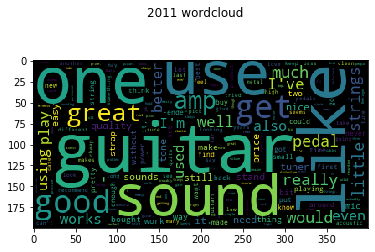

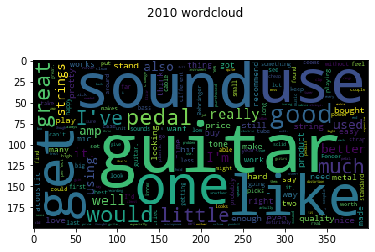

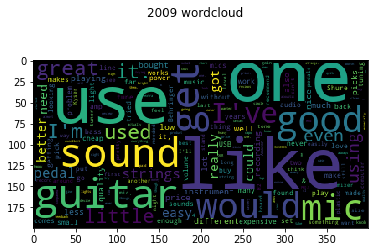

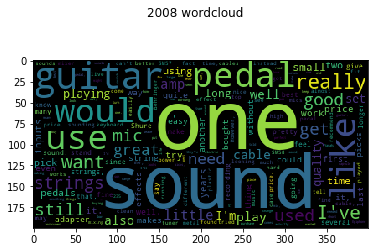

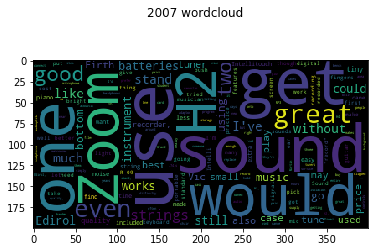

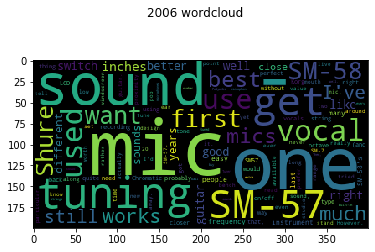

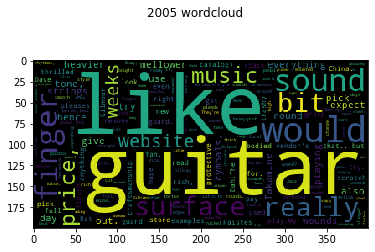

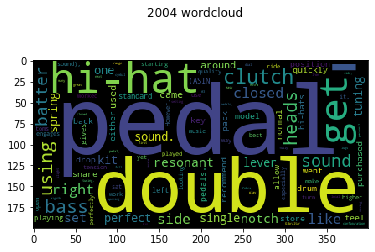

In [0]:
def flat_list(column):
    corpus = []
    for row in column:
        for w in row.split(' '):
            corpus.append(w)
    return corpus

def corpus_creator(text_col):
    corpus = text_col.rdd \
                    .flatMap(flat_list) \
                    .map(lambda x: (x, 1)) \
                    .reduceByKey(lambda x, y: x+y ) \
                    .sortBy(lambda x: x[1], ascending=False) \
                    .toDF() \
                    .withColumnRenamed('_1','reviewText') \
                    .withColumnRenamed('_2','count')
    return corpus

def annual_reviews(year):
    annual_reviews = reviews.select('text_nosw') \
                        .filter('YEAR(FROM_UNIXTIME(unixReviewTime))=={}'.format(year)) \
                        .withColumnRenamed('text_nosw','reviewText')
    return annual_reviews

def wordcloud(corpus_sdf):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['reviewText']] = row['count']
        
    wordcloud = WordCloud().generate_from_frequencies(corpus_dict)
    plt.imshow(wordcloud);


years_list = [2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004]

annual_corpora = {}
for year in years_list:
    annual_corpora[str(year)] = corpus_creator(annual_reviews(year))

for key,value in annual_corpora.items():
    fig, ax = plt.subplots()
    ax = wordcloud(value)
    fig.suptitle('{} wordcloud'.format(key))

## Entity Recognition
- The issue with the Bag of Words approach is that non-descriptive words come to the top, which aren't stopwords.
- We turn to Spark NLP's entity recognition now to filter only on Entities which would better bring popular themes to the surface

In [0]:
def make_string(x):
    string = ''
    for x in x:
        string += x + ' '
    return string

make_string = udf(make_string)
spark.udf.register("make_string", make_string)

pipeline = PretrainedPipeline('explain_document_dl', 'en')

annual_entities = {}
for year in years_list:
    entities_filtered = pipeline.transform(annual_corpora[str(year)]) \
                                .select('reviewText','count',
                                        col('entities.result').alias('entities'),
                                        col('pos.result').alias('pos'))
    entities_filtered = entities_filtered.withColumn('entities',make_string('entities'))\
                                        .withColumn('pos',make_string('pos'))\
                                        .filter('entities <> ""')
    annual_entities[str(year)] = entities_filtered
    
    
for key,value in annual_entities.items():
    fig, ax = plt.subplots()
    ax = wordcloud(value)
    fig.suptitle('{} wordcloud'.format(key))

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3869185695909332> in <module> 
 8 spark . udf . register ( "make_string" , make_string ) 
 9 
 ---> 10 pipeline = PretrainedPipeline ( 'explain_document_dl' , 'en' ) 
 11 
 12 annual_entities = { } 

 NameError : name 'PretrainedPipeline' is not defined

In [0]:
%python
def convertOverallToBoolean(overall):
  if overall > 3.0:
    return True
  else:
    return False


In [0]:
%python
s = [1,3,4,5,61,234,123, 0, 2,2]
t = map(lambda x : True if x > 3.0 else False, s)
for e in t:
  print(e)
# df3 = df2.select('overall').rdd.map(lambda x : True if x > 3.0 else False)
# df4 = spark.createDataFrame(df3).toDF("overall", "reviewText")
# df4

False
False
True
True
True
True
True
False
False
False

In [0]:
%python
df4 = spark.createDataFrame(df3)
df4.collect()

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-2832982198243311> in <module> 
 ----> 1 df4 = spark . createDataFrame ( df3 ) 
 2 df4 . collect ( ) 

 /databricks/spark/python/pyspark/databricks/utils/instrumentation.py in wrapper (self, *args, **kwargs) 
 40 try : 
 41 start_time = time . time ( ) 
 ---> 42 return_val = func ( self , * args , ** kwargs ) 
 43 except Exception : 
 44 duration = ( time . time ( ) - start_time ) * 1000 

 /databricks/spark/python/pyspark/sql/session.py in createDataFrame (self, data, schema, samplingRatio, verifySchema) 
 656 return super(SparkSession, self).createDataFrame(
 657 data, schema, samplingRatio, verifySchema)
 --> 658 return self . _create_dataframe ( data , schema , samplingRatio , verifySchema ) 
 659 
 660 def _create_dataframe ( self , data , schema , samplingRatio , verifySchema ) : 

 /databricks/spark/python/pyspark/sql/session.py in _create_dataframe (self, data, schema, samplingRatio, verifySchema) 
 686 else : 
 687 if isinstance ( data , RDD ) : 
 --> 688 rdd , schema = self . _createFromRDD ( data . map ( prepare ) , schema , samplingRatio ) 
 689 else : 
 690 rdd , schema = self . _createFromLocal ( map ( prepare , data ) , schema ) 

 /databricks/spark/python/pyspark/sql/session.py in _createFromRDD (self, rdd, schema, samplingRatio) 
 429 """
 430 if schema is None or isinstance ( schema , ( list , tuple ) ) : 
 --> 431 struct = self . _inferSchema ( rdd , samplingRatio , names = schema ) 
 432 converter = _create_converter ( struct ) 
 433 rdd = rdd . map ( converter ) 

 /databricks/spark/python/pyspark/sql/session.py in _inferSchema (self, rdd, samplingRatio, names) 
 400 : return : : class : ` pyspark . sql . types . StructType ` 
 401 """
 --> 402 first = rdd . first ( ) 
 403 if not first : 
 404 raise ValueError("The first row in RDD is empty, "

 /databricks/spark/python/pyspark/rdd.py in first (self) 
 1491 ValueError : RDD is empty
 1492 """
 -> 1493 rs = self . take ( 1 ) 
 1494 if rs : 
 1495 return rs [ 0 ] 

 /databricks/spark/python/pyspark/rdd.py in take (self, num) 
 1473 
 1474 p = range ( partsScanned , min ( partsScanned + numPartsToTry , totalParts ) ) 
 -> 1475 res = self . context . runJob ( self , takeUpToNumLeft , p ) 
 1476 
 1477 items += res

 /databricks/spark/python/pyspark/context.py in runJob (self, rdd, partitionFunc, partitions, allowLocal) 
 1225 finally : 
 1226 os . remove ( filename ) 
 -> 1227 sock_info = self . _jvm . PythonRDD . runJob ( self . _jsc . sc ( ) , mappedRDD . _jrdd , partitions ) 
 1228 return list ( _load_from_socket ( sock_info , mappedRDD . _jrdd_deserializer ) ) 
 1229 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 125 def deco ( * a , ** kw ) : 
 126 try : 
 --> 127 return f ( * a , ** kw ) 
 128 except py4j . protocol . Py4JJavaError as e : 
 129 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 
 330 raise Py4JError(

 Py4JJavaError : An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 18.0 failed 1 times, most recent failure: Lost task 0.0 in stage 18.0 (TID 20, ip-10-172-241-141.us-west-2.compute.internal, executor driver): org.apache.spark.api.python.PythonException: 'TypeError: '>' not supported between instance